<a href="https://colab.research.google.com/github/mauney/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 132
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=38.69323106073592, pvalue=3.961609200867749e-09)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## T-test Assumptions

<https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php>

- Independence of means

Are the means of our voting data independent (do not affect the outcome of one another)?
  
The best way to increase thel likelihood of our means being independent is to randomly sample (which we did not do).


In [0]:
from scipy.stats import ttest_ind

?ttest_ind

- "Homogeneity" of Variance? 

Is the magnitude of the variance between the two roughly the same?

I think we're OK on this one for the voting data, although it probably could be better, one party was larger than the other.

If we suspect this to be a problem then we can use Welch's T-test

In [0]:
?ttest_ind

- "Dependent Variable" (sample means) are Distributed Normally

<https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50>

Lots of statistical tests depend on normal distributions. We can test for normality using Scipy as was shown above.

This assumption is often assumed even if the assumption is a weak one. If you strongly suspect that things are not normally distributed, you can transform your data to get it looking more normal and then run your test. This problem typically goes away for large sample sizes (yay Central Limit Theorem) and is often why you don't hear it brought up. People declare the assumption to be satisfied either way. 



## Central Limit Theorem



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sample_means = []
for x in range(0,3000):
  coinflips = np.random.binomial(n=1, p=.5, size=12)
  one_sample = coinflips
  sample_means.append(coinflips.mean())

print(len(sample_means))
print(sample_means)

3000
[0.6666666666666666, 0.5, 0.16666666666666666, 0.25, 0.5, 0.4166666666666667, 0.4166666666666667, 0.5, 0.4166666666666667, 0.6666666666666666, 0.8333333333333334, 0.3333333333333333, 0.4166666666666667, 0.3333333333333333, 0.25, 0.4166666666666667, 0.5, 0.5833333333333334, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.5, 0.4166666666666667, 0.5833333333333334, 0.25, 0.3333333333333333, 0.4166666666666667, 0.5, 0.5833333333333334, 0.3333333333333333, 0.5, 0.5, 0.5833333333333334, 0.5, 0.6666666666666666, 0.5, 0.5, 0.6666666666666666, 0.75, 0.4166666666666667, 0.4166666666666667, 0.75, 0.5833333333333334, 0.5, 0.5, 0.6666666666666666, 0.3333333333333333, 0.4166666666666667, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.4166666666666667, 0.6666666666666666, 0.4166666666666667, 0.6666666666666666, 0.5, 0.5833333333333334, 0.6666666666666666, 0.5, 0.5, 0.3333333333333333, 0.16666666666666666, 0.5833333333333334, 0.5833333333333334, 0.6666666666666666, 0.

In [0]:
df = pd.DataFrame({'a': one_sample})
df.head()

,a
0,1
1,1
2,1
3,1
4,0


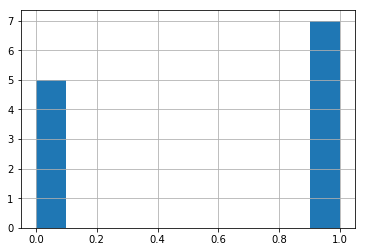

In [0]:
df.a.hist()

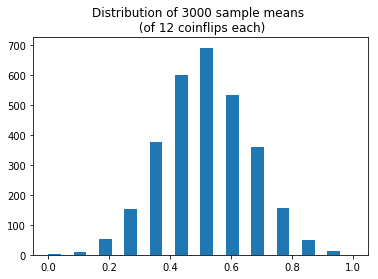

In [0]:
ax = plt.hist(sample_means, bins=24)
plt.title('Distribution of 3000 sample means \n (of 12 coinflips each)');

What does the Central Limit Theorem State? That no matter the initial distribution of the population, the distribution of sample means taken will approximate a normal distribution as $n \rightarrow \infty$.

This has very important implications for hypothesis testing and is precisely the reason why the t-distribution begins to approximate the normal distribution as our sample size increases. 

## Standard Error of the Mean

What does it mean to "estimate"? the Population mean?

## Build and Interpret a Confidence Interval

<img src="https://github.com/ryanallredblog/ryanallredblog.github.io/blob/master/img/Confidence_Interval.png?raw=true" width=400>

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

## Graphically Represent a Confidence Interval

## Relationship between Confidence Intervals and T-tests

Confidence Interval == Bounds of statistical significance for our t-test

A sample mean that falls inside of our confidence interval will "FAIL TO REJECT" our null hypothesis

A sample mean that falls outside of our confidence interval will "REJECT" our null hypothesis

In [0]:
from scipy.stats import t, ttest_1samp

In [0]:
import numpy as np

coinflip_means = []
for x in range(0,100):
  coinflips = np.random.binomial(n=1, p=.5, size=30)
  coinflip_means.append(coinflips.mean())

print(coinflip_means)

[0.7333333333333333, 0.43333333333333335, 0.5, 0.43333333333333335, 0.5, 0.5, 0.5333333333333333, 0.5, 0.4, 0.43333333333333335, 0.3333333333333333, 0.5333333333333333, 0.5333333333333333, 0.4666666666666667, 0.5, 0.6, 0.6333333333333333, 0.5, 0.3333333333333333, 0.43333333333333335, 0.4666666666666667, 0.43333333333333335, 0.4666666666666667, 0.5333333333333333, 0.43333333333333335, 0.7, 0.7, 0.5333333333333333, 0.5, 0.6666666666666666, 0.43333333333333335, 0.43333333333333335, 0.4, 0.5666666666666667, 0.5333333333333333, 0.6333333333333333, 0.4666666666666667, 0.5333333333333333, 0.36666666666666664, 0.4666666666666667, 0.4, 0.6333333333333333, 0.5666666666666667, 0.5666666666666667, 0.7333333333333333, 0.4, 0.4666666666666667, 0.6, 0.5333333333333333, 0.6333333333333333, 0.4666666666666667, 0.5333333333333333, 0.43333333333333335, 0.5, 0.36666666666666664, 0.4, 0.5666666666666667, 0.5, 0.36666666666666664, 0.5666666666666667, 0.7, 0.43333333333333335, 0.36666666666666664, 0.56666666

In [0]:
# Sample Size
n = len(coinflip_means)
# Degrees of Freedom
dof = n-1
# The Mean of Means:
mean = np.mean(coinflip_means)
# Sample Standard Deviation
sample_std = np.std(coinflip_means, ddof=1)
# Standard Error
std_err = sample_std/n**.5

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.48189276007256693, 0.5181072399274331)


In [0]:
'''You can roll your own CI calculation pretty easily. 
The only thing that's a little bit challenging 
is understanding the t stat lookup'''

# 95% confidence interval
t_stat = t.ppf(.975, dof)
print("t Statistic:", t_stat)

CI = (mean-(t_stat*std_err), mean+(t_stat*std_err))
print("Confidence Interval", CI)

t Statistic: 1.9842169515086827
Confidence Interval (0.48189276007256693, 0.5181072399274331)


A null hypothesis that's just inside of our confidence interval == fail to reject



In [0]:
ttest_1samp(coinflip_means, .49)

Ttest_1sampResult(statistic=1.0958141381351718, pvalue=0.2758187277462794)

A null hypothesis that's just outside of our confidence interval == reject



In [0]:
ttest_1samp(coinflip_means, .4818927)

Ttest_1sampResult(statistic=1.9842235343454973, pvalue=0.04999925456754134)

## Run a $\chi^{2}$ Test "by hand" (Using Numpy)

## Run a $\chi^{2}$ Test using Scipy

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

### Generate and numerically represent a confidence interval

In [0]:
# TODO - your code!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [0]:
votin_data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

categories = ['class-name', 'handicapped-infants', 'water-project-cost-sharing',
              'adoption-of-the-budget-resolution', 'physician-fee-freeze',
              'el-salvador-aid', 'religious-groups-in-schools',
              'anti-satellite-test-ban', 'aid-to-nicaraguan-contras',
              'mx-missile', 'immigration', 'synfuels-corporation-cutback',
              'education-spending', 'superfund-right-to-sue', 'crime',
              'duty-free-exports', 'export-administration-act-south-africa']

df = pd.read_csv(votin_data_url, names=categories)

In [0]:
df.replace(to_replace={'y': 1, 'n': 0, '?': np.nan}, inplace=True)

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

In [0]:
vote_info = {}
for vote in categories[1:]:
  vote_info[vote] = confidence_interval(df[vote].dropna())

In [0]:
for vote, info in vote_info.items():
  print(vote)
  print('       mean: ', info[0])
  print('lower bound: ', info[1])
  print('upper bound: ', info[2], '\n')

handicapped-infants
       mean:  0.44208037825059104
lower bound:  0.39456046308364673
upper bound:  0.48960029341753536 

water-project-cost-sharing
       mean:  0.5038759689922481
lower bound:  0.45384081311663604
upper bound:  0.5539111248678601 

adoption-of-the-budget-resolution
       mean:  0.5966981132075472
lower bound:  0.5498151808536169
upper bound:  0.6435810455614774 

physician-fee-freeze
       mean:  0.41745283018867924
lower bound:  0.37032346810896244
upper bound:  0.46458219226839603 

el-salvador-aid
       mean:  0.5047619047619047
lower bound:  0.4567501383795156
upper bound:  0.5527736711442939 

religious-groups-in-schools
       mean:  0.6415094339622641
lower bound:  0.595678078934313
upper bound:  0.6873407889902152 

anti-satellite-test-ban
       mean:  0.5676959619952494
lower bound:  0.5201811192521687
upper bound:  0.6152108047383301 

aid-to-nicaraguan-contras
       mean:  0.5761904761904761
lower bound:  0.5287372471168422
upper bound:  0.623643705

In [0]:
vote_names = [vote for vote in vote_info]
x_pos = list(range(len(vote_info)))
vote_means = [info[0] for info in vote_info.values()]
vote_error = [(info[2] - info[1]) / 2 for info in vote_info.values()]

### Graphically (with a plot) represent the confidence interval

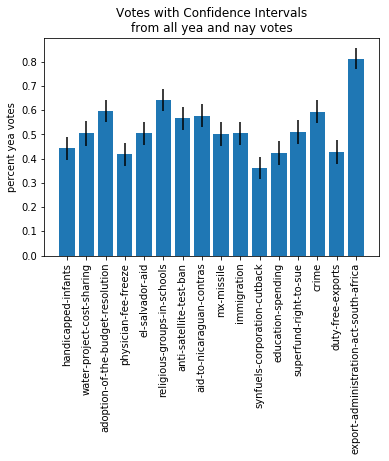

In [0]:
# plot based on example from
# https://pythonforundergradengineers.com/python-matplotlib-error-bars.html

fig, ax = plt.subplots()
ax.bar(x_pos, vote_means, yerr=vote_error)
ax.set_ylabel('percent yea votes')
ax.set_xticks(x_pos)
ax.set_xticklabels(vote_names, rotation=90)
ax.set_title('Votes with Confidence Intervals\nfrom all yea and nay votes')
plt.show()

### Interpret the confidence interval - what does it tell you about the data and its distribution?

The error bars for each vote represents where we think the population mean would lie, with a 95% confidence interval. The population in this case is some hypothetical collection of voters from which the House of Representatives was randomly chosen.

### Chi-squared test by hand using Numpy

In [0]:
adults_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adults_full_df = pd.read_csv(adults_url, header=None)
adults_df = adults_full_df.iloc[:, [3, 5]]
adults_df.columns=['education', 'marital-status']

In [0]:
adults_df.head()

,education,marital-status
0,Bachelors,Never-married
1,Bachelors,Married-civ-spouse
2,HS-grad,Divorced
3,11th,Married-civ-spouse
4,Bachelors,Married-civ-spouse


In [0]:
adults_df['education'].value_counts(dropna=False)

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

In [0]:
adults_df['marital-status'].value_counts(dropna=False)

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

In [0]:
contigency_table = pd.crosstab(adults_df['education'], adults_df['marital-status'], margins=True)
contigency_table

marital-status,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,All
education,,,,,,,,
10th,120,0,349,15,361,49,39,933
11th,130,0,354,19,586,48,38,1175
12th,39,0,130,8,232,14,10,433
1st-4th,10,0,81,12,39,9,17,168
5th-6th,20,0,172,20,89,18,14,333
7th-8th,73,0,359,14,113,23,64,646
9th,64,0,230,9,155,33,23,514
Assoc-acdm,203,2,460,12,337,30,23,1067
Assoc-voc,234,1,689,13,362,42,41,1382


#### Expected Value Calculation
\begin{align}
expected_{i,j} =\frac{(row_{i} \text{total})(column_{j} \text{total}) }{(\text{total observations})}  
\end{align}

In [0]:
contigency_table.shape

(17, 8)

In [0]:
# Get sums
row_sums = contigency_table.iloc[0:16, 7].values
col_sums = contigency_table.iloc[16, 0:7].values

print(row_sums)
print(col_sums)


[  933  1175   433   168   333   646   514  1067  1382  5355   413 10501
  1723    51   576  7291]
[ 4443    23 14976   418 10683  1025   993]


In [0]:
total = contigency_table.loc['All', 'All']
total

32561

In [0]:
expected = []
for row in row_sums:
  expected_row = []
  for column in col_sums:
    expected_val = (column * row) / total
    expected_row.append(expected_val)
  expected.append(expected_row)
  
expected = np.array(expected)
print(expected.shape)
pd.DataFrame(expected)

(16, 7)


,0,1,2,3,4,5,6
0,127.309327,0.659040,429.120973,11.977335,306.109733,29.370259,28.453334
1,160.330610,0.829981,540.425663,15.083996,385.507970,36.988268,35.833512
2,59.083536,0.305857,199.152606,5.558613,142.063788,13.630570,13.205031
3,22.923866,0.118670,77.269371,2.156691,55.119437,5.288535,5.123430
4,45.438377,0.235220,153.158932,4.274869,109.254599,10.482633,10.155370
5,88.147723,0.456313,297.119130,8.292989,211.947360,20.335678,19.700808
6,70.136114,0.363072,236.407481,6.598446,168.639231,16.180400,15.675256
7,145.593839,0.753693,490.752495,13.697552,350.074046,33.588495,32.539879
8,188.576088,0.976199,635.632567,17.741347,453.422991,43.504499,42.146310
9,730.698228,3.782593,2462.961211,68.744510,1756.932066,168.572065,163.309327


In [0]:
observed = pd.crosstab(adults_df['education'], adults_df['marital-status']).values
print(observed.shape)
pd.DataFrame(observed)

(16, 7)


,0,1,2,3,4,5,6
0,120,0,349,15,361,49,39
1,130,0,354,19,586,48,38
2,39,0,130,8,232,14,10
3,10,0,81,12,39,9,17
4,20,0,172,20,89,18,14
5,73,0,359,14,113,23,64
6,64,0,230,9,155,33,23
7,203,2,460,12,337,30,23
8,234,1,689,13,362,42,41
9,546,4,2768,68,1795,92,82


#### Chi-Squared Statistic with Numpy

\begin{align}
\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}
\end{align}

In [0]:
chi_squared = ((observed - expected)**2 / (expected)).sum()
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 1638.1373573227854


In [0]:
# Calculate Degrees of Freedom
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f"Degrees of Freedom: {dof}")

Degrees of Freedom: 90


###Chi-squared test in a single line using Scipy

In [0]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 

Chi-Squared: 1638.1373573227854
P-value: 1.1706731158022685e-282
Degrees of Freedom: 90


### Chi-squared conclusion
Due to the Chi-squared test returning a p-value of approximately zero, we reject the null hypothesis that education and marital status are independent features. The results are suggestive of an association between education and marital status.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)